<a href="https://colab.research.google.com/github/atotev/ca683-2021-dara/blob/main/NPL_on_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Applying Count Vectorization and TF IDF on movies data set**

* Attributes used: overviews, taglines, Cast, Crew and Genre

In [131]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.pyplot as plt
% matplotlib inline

In [132]:
movie_titles = pd.read_csv("/content/drive/My Drive/netflix/movie_titles_augmented.csv", sep=',', header = None,
                           names=['id', 'year', 'title', 'id_moviedb', 'genre_ids', 'vote_average', 'media_type', 'popularity', 'overview','tagline', 'genres', 'cast', 'crew'],
                      index_col = 'id', encoding = "ISO-8859-1")

movie_titles.sample(5)


,year,title,id_moviedb,genre_ids,vote_average,media_type,popularity,overview,tagline,genres,cast,crew
id,,,,,,,,,,,,
5668,1987.0,Square Dance,79615,"[18, 10749]",5,movie,3.808,An awkward 13-year-old leaves her cranky grand...,NaN,Drama|Romance,Winona Ryder|Rob Lowe|Jason Robards|Jane Alexa...,Bruce Green|Daniel Petrie|Alan Hines|Pnenah Go...
314,1985.0,Saturday Night Live: The Best of Jon Lovitz,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2852,1940.0,The Three Stooges: Nutty but Nice,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17173,1993.0,Prince: The Hits Collection,1892,"[35, 10751, 18]",8,tv,37.397,Luke Skywalker leads a mission to rescue his f...,The Empire Falls...,Adventure|Action|Science Fiction,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,George Lucas|George Lucas|George Lucas|George ...
16091,1997.0,Firelight,38621,"[10749, 18]",6,movie,6.115,In 1838 lovely governess Elisabeth agrees to ...,Passion has no limits.,Romance|Drama,Sophie Marceau|Stephen Dillane|Dominique Belco...,William Nicholson|William Nicholson|John Hubba...


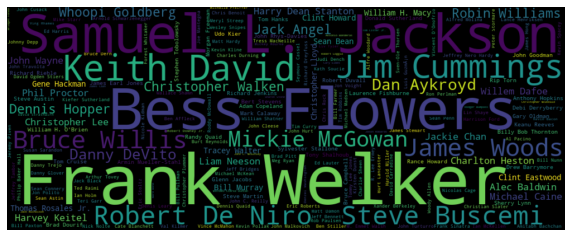

In [133]:
cast_popularity = (movie_titles["cast"].str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
cast_wc = WordCloud(width=1000,height=400)
cast_wc.generate_from_frequencies(cast_popularity.to_dict())

plt.figure(figsize = (10,10))
plt.imshow(cast_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

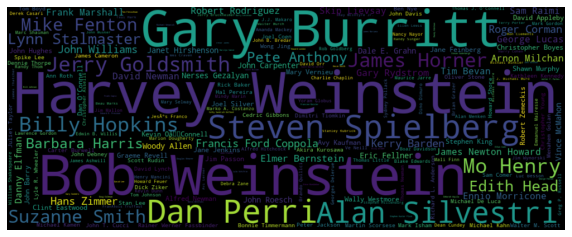

In [134]:
crew_popularity = (movie_titles["crew"].str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))

crew_wc = WordCloud(width=1000,height=400)
crew_wc.generate_from_frequencies(crew_popularity.to_dict())

plt.figure(figsize = (10,10))
plt.imshow(crew_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

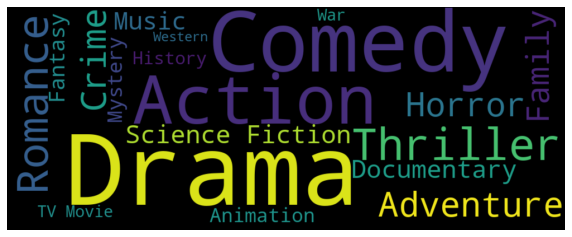

In [135]:
genre_popularity = (movie_titles["genres"].str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_wc = WordCloud(width=1000,height=400)
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize = (10,10))
plt.imshow(genre_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [136]:
#Replace NaN with an empty string
movie_titles['genres'] = movie_titles['genres'].fillna('')
movie_titles['overview'] = movie_titles['overview'].fillna('')
movie_titles['cast'] = movie_titles['cast'].fillna('')
movie_titles['crew'] = movie_titles['crew'].fillna('')
movie_titles['tagline'] = movie_titles['tagline'].fillna('')

def clean_data(x):
  return str.lower(x.replace(" ", ""))

features = ['cast', 'tagline', 'genres', 'crew']
for feature in features:
    movie_titles[feature] = movie_titles[feature].apply(clean_data)


movie_titles['words'] =  movie_titles['genres'] + ' ' + movie_titles['cast'] 

movie_titles.sample(10)

,year,title,id_moviedb,genre_ids,vote_average,media_type,popularity,overview,tagline,genres,cast,crew,words
id,,,,,,,,,,,,,
6706,1999.0,Simply Irresistible,16172,"[35, 10749]",5,movie,10.622,After her mother's death mediocre chef Amanda...,magicopeneduptheirhearts...lovedidtherest.,comedy|romance,sarahmichellegellar|seanpatrickflanery|dylanba...,suzannesmith|arnonmilchan|billyhopkins|josephm...,comedy|romance sarahmichellegellar|seanpatrick...
17560,1984.0,Ghostbusters,43074,"[28, 14, 35]",5,movie,58.292,Following a ghost invasion of Manhattan paran...,whoyougonnacall?,action|fantasy|comedy,melissamccarthy|kristenwiig|katemckinnon|lesli...,danaykroyd|danaykroyd|haroldramis|beatfrutiger...,action|fantasy|comedy melissamccarthy|kristenw...
8486,1994.0,The Wedding Gift,557045,"[35, 18]",0,movie,0.600,The Wedding Gift tells a tale of a mother a s...,,comedy|drama,liljaãã³risdã³ttir|hafsteinngunnarhafsteinsson,aronãã³rleifsson|aronãã³rleifsson,comedy|drama liljaãã³risdã³ttir|hafsteinngunn...
9696,2000.0,Fart: The Movie,2173,[35],4,movie,7.690,A man and his buddies learn to deal with love ...,,comedy,sethwalther|kevinfarley|heathermccomb|christin...,mattberman|mattberman|mattberman|tonycostanzo|...,comedy sethwalther|kevinfarley|heathermccomb|c...
1073,2005.0,Coach Carter,7214,"[18, 36]",7,movie,29.272,Based on a true story in which Richmond High ...,itbeginsonthestreet.itendshere.,drama|history,samuell.jackson|robbrown|robertri'chard|rickgo...,trevorrabin|sarahhalleyfinn|randihiller|vantof...,drama|history samuell.jackson|robbrown|robertr...
17063,2000.0,The Crocodile Hunter,17043,"[10751, 12, 35]",5,movie,9.856,Steve Irwin AKA The Crocodile Hunter has avo...,hisfirstbig-screenadventure!,family|adventure|comedy,steveirwin|terriirwin|magdaszubanski|davidwenh...,brucewillis|arnoldrifkin|davidburr|hollygoldbe...,family|adventure|comedy steveirwin|terriirwin|...
1493,1980.0,John Lee Hooker: Live in Montreal: Montreal Ja...,0,NaN,0,NaN,NaN,,,,,,
13890,1999.0,Touching Evil: Series 3,10622,"[18, 80, 9648]",7,tv,2.279,A Chinese chef accidentally gets involved with...,fightfirst.apologizelater.,crime|action|comedy,jackiechan|richardnorton|mikilee|gabriellefitz...,j.peterrobinson|edwardtang|fibema|petercheung|...,crime|action|comedy jackiechan|richardnorton|m...
6349,2003.0,Sinatra: The Classic Duets,63903,"[36, 80, 18]",5,movie,3.030,In need of a grubstake a young man convinces ...,what'salittlekidnappingamongfriends?,history|crime|drama,davidarquette|williamh.macy|thomasiannicholas|...,heikebrandstatter|coreenmayrs|johnpowell|tinah...,history|crime|drama davidarquette|williamh.mac...


In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
#vectorized representation of words in a document
#it gives us a matrix where each column represents a word in the overview
tfidf = TfidfVectorizer(stop_words='english', min_df=2)

tfidf_matrix = tfidf.fit_transform(movie_titles['overview'] + ' ' + movie_titles['tagline'])

from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


print(tfidf.get_feature_names())

print(tfidf_matrix.shape)



['00', '000', '007', '0093', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '1001problems', '100th', '101', '103', '108', '10th', '11', '110', '1138', '116', '1183', '11th', '12', '120', '1250', '127', '12th', '13', '135', '13th', '14', '1429', '14th', '15', '150', '1542', '15th', '15yearsofimprisonmentfivedaysofvengeance', '15âº', '16', '1600s', '1601', '161', '1650', '1691', '16mm', '16th', '17', '1700s', '175', '1776', '1797', '17th', '18', '180', '1800', '1800s', '1815', '1816', '1818', '1820', '1825', '1830s', '1831', '1836', '1840', '1841', '1850s', '1851', '1852', '1860s', '1862', '1863', '1864', '1865', '1870', '1870s', '1871', '1880s', '1882', '1885', '1888', '1889', '1890', '1890s', '1893', '1895', '1897', '18th', '18â', '19', '190', '1900', '1900s', '1904', '1906', '1908', '1910', '1910s', '1911', '1912', '1914', '1916', '1917', '1918', '1919', '1920', '1920s', '1921', '1922', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1930s', '1931'

In [138]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = int(movie_titles[movie_titles["title"] == title].index[0]-1)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_titles['title'].iloc[movie_indices]

In [139]:
print(get_recommendations('Dinosaur Planet'))

id
17705                           Evil Alien Conquerors
2547                                 Green Legend Ran
13586    Allosaurus: A Walking with Dinosaurs Special
16084                            Entrails of a Virgin
12447       The Land Before Time VIII: The Big Freeze
3915                     The Brothers Quay Collection
13208                                    High Crusade
13085                                   Bikini Summer
15433                                 Bikini Summer 2
1173                           Walking with Dinosaurs
Name: title, dtype: object


In [140]:
from sklearn.feature_extraction.text import CountVectorizer

#Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
#TfidfVectorizer() assigns a score while CountVectorizer() counts.

count = CountVectorizer(stop_words='english', min_df=2,ngram_range=(1,1))
count_matrix = count.fit_transform(movie_titles['words'])

print(count.vocabulary_)


{'adventure': 360, 'sciencefiction': 41103, 'erinbrown': 13403, 'tinakrause': 44968, 'rubylarocca': 40044, 'documentary': 11280, 'markmetcalf': 29695, 'paulaabdul': 35264, 'jerrylawler': 20818, 'petersenercia': 36250, 'michaelmanna': 31576, 'scargutiã': 41080, 'rrezrubio': 40022, 'scottlevy': 41197, 'dioniciocastellanos': 11232, 'johnwatson': 22819, 'jimfullington': 21143, 'sabu': 40386, 'scottbigelow': 41137, 'robvandam': 39265, 'jeremylynn': 20722, 'chrisbenoit': 7347, 'eddieguerrero': 12199, 'steveaustin': 43030, 'horror': 17878, 'debbierochon': 10481, 'johnmigliore': 22488, 'animation': 2135, 'action': 122, 'marleematlin': 29812, 'elainehendrix': 12618, 'robertblanche': 38690, 'robertbaileyjr': 38670, 'kirkthornton': 25617, 'michelleruff': 31980, 'michaelsorich': 31756, 'steveblum': 43040, 'tomfahn': 45197, 'comedy': 8509, 'brickbronsky': 5369, 'lisagaye': 27529, 'leesarowland': 26728, 'scottresnick': 41233, 'robertdawson': 38750, 'philrivo': 36585, 'troyfromin': 45978, 'paulborghe

In [141]:
count_matrix.shape

(17770, 48451)

In [142]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [143]:
#by overview and tagline
get_recommendations('Lilo and Stitch', cosine_sim)


id
14113                   Stitch! The Movie
11805                      The Big Bounce
15281                           Blue Seed
14868                   Lilo and Stitch 2
666            The Man Who Came to Dinner
4300        Kumu Hula: Keepers of Culture
15429               The Fox and the Hound
8894     Cane Toads: An Unnatural History
6383                 Benji: Off the Leash
8528                       American Aloha
Name: title, dtype: object

In [144]:
#by genre and cast
get_recommendations('Lilo and Stitch', cosine_sim2)

id
14113                                    Stitch! The Movie
14868                                    Lilo and Stitch 2
510                Blue's Clues: Blue's Room: It's Hug Day
893                            Blue's Clues: Classic Clues
1512     Blue's Clues: Blue's Room: Beyond Your Wildest...
1710                       Dora the Explorer: Super Babies
1859                  Baby Genius: Favorite Nursery Rhymes
2833          Blue's Clues: Blue's Room Snacktime Playdate
4344                Dora the Explorer: Dance to the Rescue
4470                              Blue's Clues: Blue Talks
Name: title, dtype: object

In [145]:
#by overview
print(get_recommendations('Jurassic Park III', cosine_sim))

id
4216                        Jurassic Park III
14319                                 Fingers
4498                                    Gonin
13891     Nymphoid Barbarian in Dinosaur Hell
13319                           Anything Else
15414                           The Mangler 2
3386                                 Blacktop
13353    Paul McCartney: In the World Tonight
11479                         Head Over Heels
16211                                No Alibi
Name: title, dtype: object


In [146]:
#by genre and cast
print(get_recommendations('Jurassic Park III', cosine_sim2))

id
4216                                     Jurassic Park III
13363                                          Saint Seiya
3363                                                  Grim
7693                                    Six-String Samurai
3488                                           Dark Heaven
1151                                             Valentine
7868                                              Gasaraki
8601               Rebirth of Mothra 1 & 2: Double Feature
17040                                           Gang Tapes
11365    Gamera: Return of the Giant Monsters / The Mag...
Name: title, dtype: object
